# Multiclass Image Classification

## Dataset Prepration

In [126]:
import numpy as np
import os
from pathlib import Path 
from keras.preprocessing import image

In [127]:
p=Path("Datasets/Images/images/")
dirs=p.glob("*")
labels_dict={"cat":0,"dog":1,"horse":2,"human":3}
image_data=[]
labels=[]

for folder_dir in dirs:
  
    label=str(folder_dir).split("\\")[-1][:-1]
    
    for img_path in folder_dir.glob("*.jpg"):
        img=image.load_img(img_path,target_size=(32,32))
        img_array=image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])






In [128]:
print(len(image_data))
print(len(labels))

808
808


In [129]:
#convert into numpy array

image_data=np.array(image_data,dtype='float32')/255.0
labels=np.array(labels)

print(image_data.shape,labels.shape)

(808, 32, 32, 3) (808,)


## Random Suffling and Data Visualise

In [130]:
import random
combined=list(zip(image_data,labels))
random.shuffle(combined)

#unzip
image_data[:],labels[:]=zip(*combined)

In [131]:
def drawImg(img):
    from matplotlib import pyplot as plt
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return

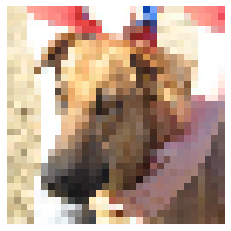

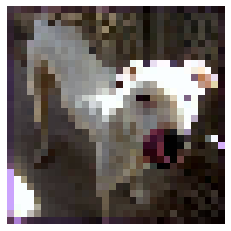

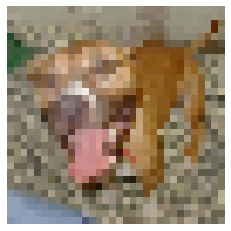

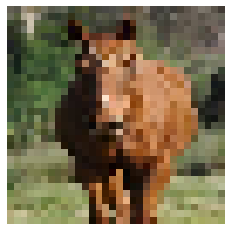

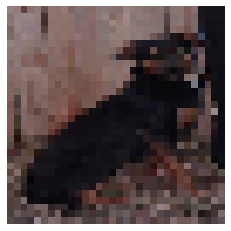

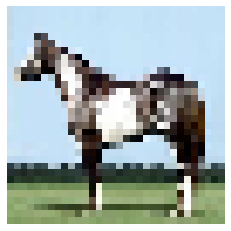

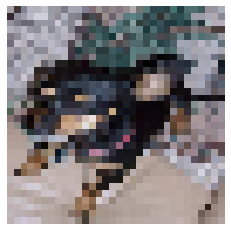

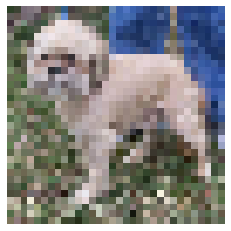

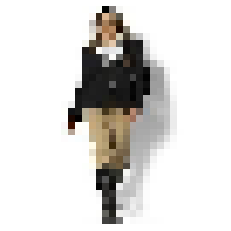

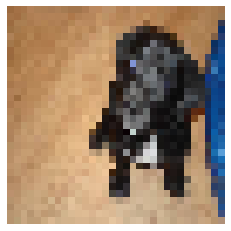

In [132]:
for i in range(10):
    drawImg(image_data[i])

# Svm Classifier

In [133]:
class SVM:
    
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=100,learning_rate=0.001,maxItr=300):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update rule that we discussed!
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses
    
    
                

## we need to convert data for One-for-One classification!


In [134]:
M=image_data.shape[0]
image_data=image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

(808, 3072)
(808,)


In [135]:
CLASSES=len(np.unique(labels))
print(CLASSES)

4


In [136]:
def ClasswiseDAta(x,y):
    data={}

    for i in range(CLASSES):
        data[i]=[]
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])

    for k in data.keys():
        data[k]=np.array(data[k])

    return data


In [137]:
data=ClasswiseDAta(image_data,labels)

In [138]:
print(data[0].shape)
print(data[1].shape[0])
print(data[2].shape[0])
print(data[3].shape[0])


(202, 3072)
202
202
202


In [139]:
def getDatapair(d1,d2):
    """combine data of two class into matrix"""
    l1,l2=d1.shape[0],d2.shape[0]

    samples=l1+l2
    features=d1.shape[1]
    data_pair=np.zeros((samples,features))

    data_labels=np.zeros((samples,))

    data_pair[:l1,:]=d1
    data_pair[l1:,:]=d2

    data_labels[:l1]=-1
    data_labels[l1:]=+1

    return data_pair,data_labels



## Training VC2 Svm Part!

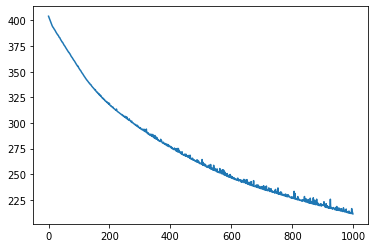

In [140]:
import matplotlib.pyplot as plt
mySvm=SVM()
xp, yp =getDatapair(data[0],data[1])
w,b,loss=mySvm.fit(xp,yp,learning_rate=0.00001,maxItr=1000)
plt.plot(loss)


In [143]:
def trainSvm(x,y):
    svm_classifier={}
    for i in range(CLASSES):
        svm_classifier[i]={}
        for j in range(i+1,CLASSES):
            xpair,ypair=getDatapair(data[i],data[j])
            wts,b,loss=mySvm.fit(xpair,ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifier[i][j]=(wts,b)

    return svm_classifier

In [144]:
svm_classifier= trainSvm(image_data,labels)

In [145]:
# parameyers for cats and dogs

cats_dogs=svm_classifier[0][1]
cats_humans=svm_classifier[0][3]



## Prediction


In [146]:
def binaryPredict(x,w,b):
    z=np.dot(x,w.T) +b
    if z>=0:
        return 1
    else:
        return -1
        

In [147]:
def predict(x):
    count=np.zeros((CLASSES,))

    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b=svm_classifier[i][j]
            #take a majority prediction
            z=binaryPredict(x,w,b)

            if(z==1):
                count[j] += 1
            
            else:
                count[i] += 1
    final_prediction=np.argmax(count)
    #print(count)
    return final_prediction


In [148]:
print(predict(image_data[0]))
print(labels[0])

0
1


In [149]:
def accuracy(x,y):
    count=0
    for i in range(x.shape[0]):
        prediction=predict(x[i])
        if(prediction==y[i]):
            count += 1
    return count/x.shape[0]


In [150]:
accuracy(image_data,labels)

0.5952970297029703

## scikit

In [174]:
from sklearn import svm



In [180]:
svm_classifier=svm.SVC(kernel='rbf',C=1000.0)

In [181]:
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)

0.6497524752475248